**Raport dotyczący analizy EKG**. Podczas doświadczenia zebrano 4 różne sygnału EKG. Różniły się one sytuacjami, w których były pobierane tj. wyróżniono: sygnał spoczynkowy (sygnał podczas spoczynku), sygnał relaksujący (sygnał podczas słuchania/oglądania relaksującego materiału), sygnał stresujący/pobudzający (sygnał podczas oglądania/słuchania stresującego/pobudzającego materiału), sygnał fizyczny (sygnał zebrany po wysiłku fizycznym). Po odpowiednim zebraniu sygnałów tj. przyczepieniu elektrod do prawej i lewej ręki oraz prawej i lewej nogi, gdzie prawa noga służyła za uziemienie, zaczęto analize danych sygnałów.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.signal as ss
import gdown
import matplotlib.patches as patches

In [3]:
gdown.download('https://drive.google.com/uc?id=15bfc6ufnCPW-S3XWTRqJh0YaWK1yGaVk&export=download')
gdown.download('https://drive.google.com/file/d/1n-W5WbO_eqp1pk0q7Usmp3-mqPKdNzL6/view?usp=sharing', fuzzy=True) # Use fuzzy=True for links with 'view'
gdown.download('https://drive.google.com/file/d/14ELHXjuEb_Zo54WZElQHUPLgoHc2K3Rw/view?usp=sharing', fuzzy=True) # Use fuzzy=True for links with 'view'
gdown.download('https://drive.google.com/file/d/1Ou5PnBNrlR5lSQ2EngB59-GLzRcpndWI/view?usp=sharing', fuzzy=True) # Use fuzzy=True for links with 'view'

Downloading...
From: https://drive.google.com/uc?id=15bfc6ufnCPW-S3XWTRqJh0YaWK1yGaVk&export=download
To: /content/EKGfizyczny.obci.raw
100%|██████████| 7.55M/7.55M [00:00<00:00, 14.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n-W5WbO_eqp1pk0q7Usmp3-mqPKdNzL6
To: /content/EKGrelaksujący.obci.raw
100%|██████████| 3.68M/3.68M [00:00<00:00, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=14ELHXjuEb_Zo54WZElQHUPLgoHc2K3Rw
To: /content/EKGstresującypobudzajacy.obci.raw
100%|██████████| 4.42M/4.42M [00:00<00:00, 13.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ou5PnBNrlR5lSQ2EngB59-GLzRcpndWI
To: /content/EKGspoczynkowy1.obci.raw
100%|██████████| 3.73M/3.73M [00:00<00:00, 105MB/s]


'EKGspoczynkowy1.obci.raw'

### **Ćwiczenie 1:** Wczytuje oraz filtruje sygnał trzema filtrami tj. górnoprzepustowym, dolnoprzepustowym oraz filtrem notch. Następnie pisze funkcje do określenia konkretnego montażu elektrod

Na początku wczytano sygnały, dzieląc je na 3 kanały(odpowiednio noga,lewa ręka, prawa ręka), a następnioe przefiltrowano filtrem górnoprzepustowym z częstością odcięcia 0.67 Hz, później filtrem dolnoprzepustowym z częstością odcięcia 150Hz, a na sam koniec filtrem typu notch dla 50 Hz. Do wykreślenia sygnałów możemy stosować różne montaże. W tym ćwiczeniu użyto dwóch montaży tj. Einthovena oraz Goldberga. Dla montażu Einthovena odprowadzenia kończynowe mierzą różnicę napięć pomiędzy miejscami przyłożenia elektrod w następujący sposób: I = VL - VR, II = VF - VR, III = VF- VL, gdzie VL - potencjał na lewej ręce, VR - potencjał na prawej ręce, VF - potencjał na nodze. W odróżnieniu od Einthovena, montaż Goldberga to różnica napięc pomiędzy elektrodą pomiarową, a średnim napięciem na dwóch pozostałych elektrodach np. aVR = VR - (VL+VF)/2

In [4]:
Fs = 2048

def wczytywanie(file_path):
    """Wczytuje dane EKG z pliku i zwraca trzy kanały."""
    data = np.fromfile(file_path, dtype="float32").reshape(-1, 3)
    return data[:, 0], data[:, 1], data[:, 2]

def filtry(signal, Fs):
    """Filtruje sygnał EKG: filtr górnoprzepustowy, dolnoprzepustowy i notch."""
    sos_high = ss.butter(8, 0.67, fs=Fs, btype="high", output="sos")
    sos_low = ss.butter(2, 150, fs=Fs, btype="low", output="sos")
    b_notch, a_notch = ss.iirnotch(50, Q=30, fs=Fs)

    signal = ss.sosfiltfilt(sos_high, signal)
    signal = ss.sosfiltfilt(sos_low, signal)
    signal = ss.lfilter(b_notch, a_notch, signal)
    return signal


def montaz_goldberga(ekg1, ekg2, ekg3):

    aV1 = (ekg3 - ((ekg1 + ekg2) / 2)) * 0.0715
    aV2 = (ekg2 - ((ekg1 + ekg3) / 2)) * 0.0715
    aV3 = (ekg1 - ((ekg2 + ekg3) / 2)) * 0.0715

    return aV1, aV2, aV3

def montaz_einthovena(ekg1, ekg2, ekg3):
    """Oblicza różne montaże EKG."""
    V1 =( ekg2 - ekg3 ) * 0.0715
    V2 =( ekg1 - ekg3 )* 0.0715
    V3 = (ekg1 - ekg2  )* 0.0715

    return V1, V2, V3

def znajdz_interwaly_ekg(signal, Fs):
    """
    Znajduje interwały EKG: P, PQ, QRS, ST, T i U
    Wykorzystuje detekcję QRS, a następnie szacuje pozostałe interwały
    """
    # Znajdowanie pików R
    peaks, _ = ss.find_peaks(signal, height=0.4*max(signal), distance=0.5*Fs)

    if len(peaks) >= 2:
        r_peak = peaks[0]
        next_r = peaks[1]

        # Szacowany czas trwania interwałów (w próbkach)
        p_start = int(r_peak - 0.25*Fs)
        p_end = int(r_peak - 0.12*Fs)
        q_start = int(r_peak - 0.05*Fs)
        s_end = int(r_peak + 0.05*Fs)
        t_start = int(r_peak + 0.08*Fs)
        t_end = int(r_peak + 0.35*Fs)
        u_end = min(int(r_peak + 0.45*Fs), next_r)

        # Interwały
        interwaly = {
            "P": (p_start, p_end),
            "PQ": (p_end, q_start),
            "QRS": (q_start, s_end),
            "ST": (s_end, t_start),
            "T": (t_start, t_end),
            "U": (t_end, u_end)
        }

        # Obliczenie odstępów PQ i QT (w sekundach)
        odstep_pq = (q_start - p_start) / Fs
        odstep_qt = (t_end - q_start) / Fs

        return interwaly, odstep_pq, odstep_qt, r_peak
    else:
        return None, 0, 0, 0

def wyswietl_ekg_z_interwalami(signal, Fs, interwaly, odstep_pq, odstep_qt, r_peak):
    """Wyświetla sygnał EKG z zaznaczonymi kolorowymi interwałami."""
    t_start = max(0, r_peak - int(0.3*Fs))
    t_end = min(len(signal), r_peak + int(0.6*Fs))

    segment = signal[t_start:t_end]
    t = np.arange(0, len(segment)/Fs, 1/Fs)

    # Kolory dla interwałów
    colors = {
        "P": "#ffb3b3",     # różowy
        "PQ": "#ffe6b3",    # żółty
        "QRS": "#ccffb3",   # jasnozielony
        "ST": "#b3ffcc",    # zielony
        "T": "#b3e6ff",     # niebieski
        "U": "#e6b3ff"      # fioletowy
    }

    fig, ax = plt.figure(figsize=(9, 4)), plt.gca()

    ax.plot(t, segment, color='black', linewidth=1.5)
    ax.set_title("Analiza odstępów EKG (aVR)", fontsize=10)
    ax.set_xlabel("Czas (s)", fontsize=8)
    ax.set_ylabel("Amplituda (mV)", fontsize=8)

    y_min = min(segment) - 0.1 * (max(segment) - min(segment))
    y_max = max(segment) + 0.1 * (max(segment) - min(segment))


    for nazwa, (start, end) in interwaly.items():
        rel_start = max(0, start - t_start)
        rel_end = min(end - t_start, len(segment) - 1)

        if rel_start < len(t) and rel_end < len(t) and rel_start < rel_end:
            rect = patches.Rectangle(
                (t[rel_start], y_min),
                t[rel_end] - t[rel_start],
                y_max - y_min,
                linewidth=1,
                edgecolor=None,
                facecolor=colors[nazwa],
                alpha=0.7,
                zorder=0
            )
            ax.add_patch(rect)

            ax.text(
                (t[rel_start] + t[rel_end]) / 2,
                y_max + 0.05 * (y_max - y_min),
                f"ZAŁAMEK\n{nazwa}",
                horizontalalignment='center',
                fontsize=5,
                fontweight='bold'
            )

    pq_start = interwaly["P"][0] - t_start
    pq_end = interwaly["QRS"][0] - t_start

    if 0 <= pq_start < len(t) and 0 <= pq_end < len(t):
        ax.annotate(
            f"ODSTĘP PQ\n{odstep_pq:.3f}s",
            xy=((t[pq_start] + t[pq_end]) / 2, y_min + 0.15 * (y_max - y_min)),
            xytext=((t[pq_start] + t[pq_end]) / 2, y_min + 0.15 * (y_max - y_min)),
            fontsize=5,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="#b3964d", alpha=0.7),
            ha='center'
        )

    qt_start = interwaly["QRS"][0] - t_start
    qt_end = interwaly["T"][1] - t_start

    if 0 <= qt_start < len(t) and 0 <= qt_end < len(t):
        ax.annotate(
            f"ODSTĘP QT\n{odstep_qt:.3f}s",
            xy=((t[qt_start] + t[qt_end]) / 2, y_min + 0.15 * (y_max - y_min)),
            xytext=((t[qt_start] + t[qt_end]) / 2, y_min + 0.15 * (y_max - y_min)),
            fontsize=5,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="#b3964d", alpha=0.7),
            ha='center'
        )

    odcinek_pq = patches.Rectangle(
        (t[interwaly["PQ"][0] - t_start], y_min),
        t[interwaly["PQ"][1] - t_start] - t[interwaly["PQ"][0] - t_start],
        0.05 * (y_max - y_min),
        linewidth=1,
        edgecolor='black',
        facecolor="#b3964d",
        alpha=0.5,
        zorder=2
    )
    ax.add_patch(odcinek_pq)

    odcinek_st = patches.Rectangle(
        (t[interwaly["ST"][0] - t_start], y_min),
        t[interwaly["ST"][1] - t_start] - t[interwaly["ST"][0] - t_start],
        0.05 * (y_max - y_min),
        linewidth=1,
        edgecolor='black',
        facecolor="#b3964d",
        alpha=0.5,
        zorder=2
    )
    ax.add_patch(odcinek_st)

    ax.text(
        (t[interwaly["PQ"][0] - t_start] + t[interwaly["PQ"][1] - t_start]) / 2,
        y_min + 0.025 * (y_max - y_min),
        "ODCINEK PQ",
        horizontalalignment='center',
        fontsize=5,
        color='black'
    )

    ax.text(
        (t[interwaly["ST"][0] - t_start] + t[interwaly["ST"][1] - t_start]) / 2,
        y_min + 0.025 * (y_max - y_min),
        "ODCINEK ST",
        horizontalalignment='center',
        fontsize=5,
        color='black'
    )

    ax.set_ylim(y_min, y_max + 0.2 * (y_max - y_min))

    plt.figtext(0.02, 0.02,
                f"Odstęp PQ: {odstep_pq:.3f}s (norma: 0.12-0.20s)\n"
                f"Odstęp QT: {odstep_qt:.3f}s (norma: 0.35-0.44s przy rytmie 60-100/min)",
                fontsize=5)

    plt.tight_layout()
    return fig


### **Ćwiczenie 2**:Teraz kolejno dla poszczególnych sygnałów będe wykreślał ich wykresy w montażach:
Einthovena oraz Goldberga

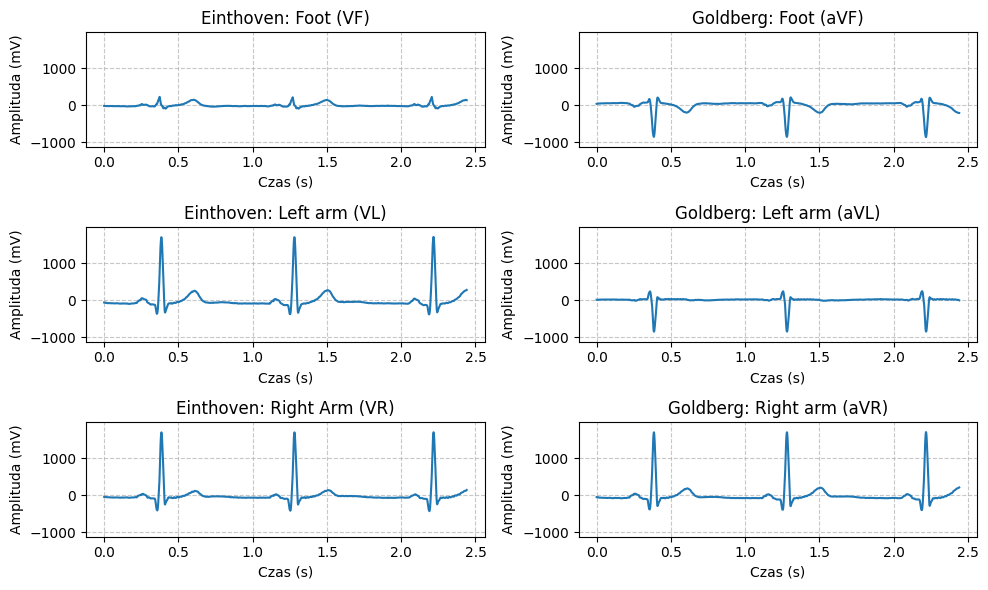

In [5]:
# SYGNAŁ RELAKSUJĄCY

ekg1, ekg2, ekg3 = wczytywanie("EKGrelaksujący.obci.raw")
filtered1 = filtry(ekg1, Fs)
filtered2 = filtry(ekg2, Fs)
filtered3 = filtry(ekg3, Fs)

# Montaż Einthovena
noga, lewa, prawa = montaz_einthovena(filtered1, filtered2, filtered3)
t = np.arange(0, len(noga[5000:10000]) / Fs, 1 / Fs)

# Montaż Goldberga
nogaG, lewaG, prawaG1 = montaz_goldberga(filtered1, filtered2, filtered3)
tG = np.arange(0, len(nogaG[5000:10000]) / Fs, 1 / Fs)

# Przygotowanie danych do wyświetlenia
einthoven_data = [noga[5000:10000], lewa[5000:10000], prawa[5000:10000]]
goldberg_data = [nogaG[5000:10000], lewaG[5000:10000], prawaG1[5000:10000]]

# Znalezienie globalnych min i max dla wszystkich sygnałów
all_data = np.concatenate(einthoven_data + goldberg_data)
y_min = np.min(all_data)
y_max = np.max(all_data)

# Dodanie marginesu do wartości skrajnych dla lepszej wizualizacji
margin = (y_max - y_min) * 0.1
y_min -= margin
y_max += margin

# Tworzenie wykresów
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

titles_einthoven = ["Einthoven: Foot (VF)", "Einthoven: Left arm (VL)", "Einthoven: Right Arm (VR)"]
titles_goldberg = ["Goldberg: Foot (aVF)", "Goldberg: Left arm (aVL)", "Goldberg: Right arm (aVR)"]

for i in range(3):
    # Einthoven
    axs[i, 0].plot(t, einthoven_data[i])
    axs[i, 0].set_title(titles_einthoven[i])
    axs[i, 0].set_ylim(y_min, y_max)

    # Goldberg
    axs[i, 1].plot(tG, goldberg_data[i])
    axs[i, 1].set_title(titles_goldberg[i])
    axs[i, 1].set_ylim(y_min, y_max)

for ax in axs.flat:
    ax.set_xlabel("Czas (s)")
    ax.set_ylabel("Amplituda (mV)")
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



---


Jak widać na powyższych wykresach, dla sygnału relaksującego, montaże są dosyć "gładkie" i ładnie obrazują poszczególne składowe sygnału EKG. Z innych rzeczy można zaobserwować różnice w kierunku pików R w poszcególnych odnogach np. przy rozpatrywaniu odnogi z lewej ręki widać różnice w kierunku pików R, a także wielkości np. pików P, T. Jest to całkowicie normalne ponieważ, każdy z montażów „obserwuje” wektor depolaryzacji serca z innej perspektywy, stąd różnice w wyglądzie i wysokości załamków.


---





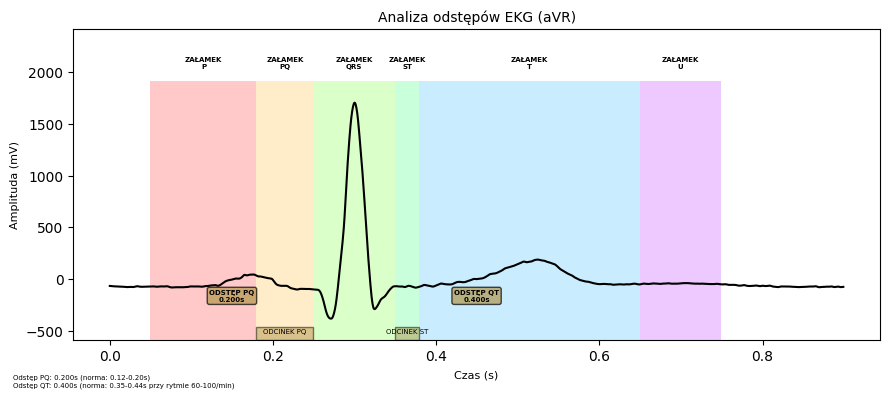

In [6]:
signal_segment = prawaG1[5000:10000]

# Znajdź interwały
interwaly, odstep_pq, odstep_qt, r_peak = znajdz_interwaly_ekg(signal_segment, Fs)

if interwaly:
    # Wyświetl sygnał z zaznaczonymi interwałami
    fig = wyswietl_ekg_z_interwalami(signal_segment, Fs, interwaly, odstep_pq, odstep_qt, r_peak)
    plt.show()
else:
    print("Nie udało się wykryć odpowiednich punktów w sygnale EKG.")



---


W obrazie wyraźnie uwidoczniono elementy cyklu sercowego – załamek P, odstęp PQ, zespół QRS, odcinek ST oraz załamek T – przy jednoczesnym zachowaniu prawidłowych czasów trwania, co potwierdza poprawność przewodzenia i repolaryzacji.

---



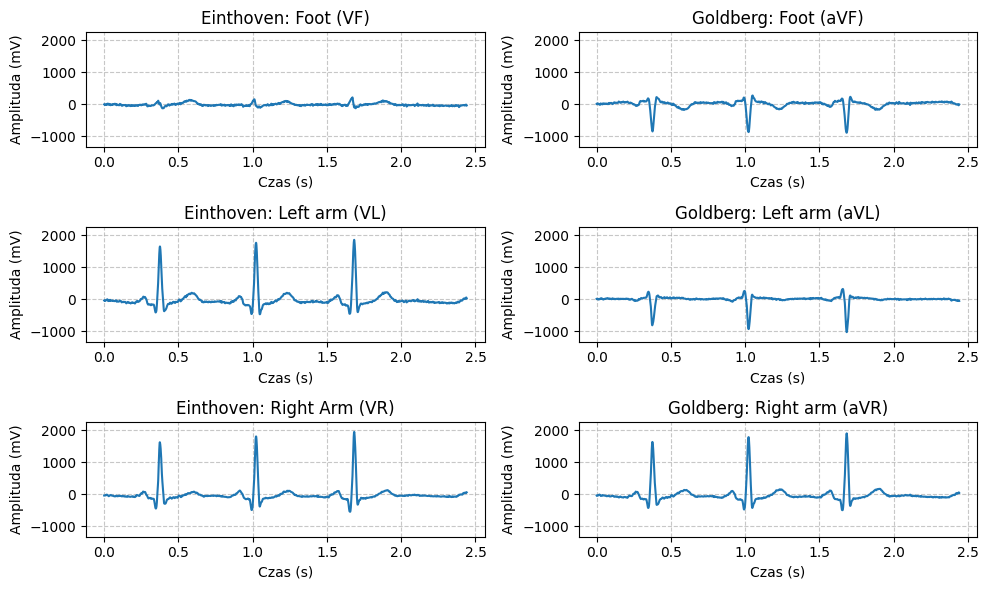

In [7]:
# SYGNAŁ SPOCZYNKOWY

ekg1, ekg2, ekg3 = wczytywanie("EKGspoczynkowy1.obci.raw")
filtered1 = filtry(ekg1, Fs)
filtered2 = filtry(ekg2, Fs)
filtered3 = filtry(ekg3, Fs)

# Montaż Einthovena
noga, lewa, prawa = montaz_einthovena(filtered1, filtered2, filtered3)
t = np.arange(0, len(noga[5000:10000]) / Fs, 1 / Fs)

# Montaż Goldberga
nogaG, lewaG, prawaG1 = montaz_goldberga(filtered1, filtered2, filtered3)
tG = np.arange(0, len(nogaG[5000:10000]) / Fs, 1 / Fs)

# Przygotowanie danych do wyświetlenia
einthoven_data = [noga[5000:10000], lewa[5000:10000], prawa[5000:10000]]
goldberg_data = [nogaG[5000:10000], lewaG[5000:10000], prawaG1[5000:10000]]

# Znalezienie globalnych min i max dla wszystkich sygnałów
all_data = np.concatenate(einthoven_data + goldberg_data)
y_min = np.min(all_data)
y_max = np.max(all_data)

# Dodanie marginesu do wartości skrajnych dla lepszej wizualizacji
margin = (y_max - y_min) * 0.1
y_min -= margin
y_max += margin

# Tworzenie wykresów
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

titles_einthoven = ["Einthoven: Foot (VF)", "Einthoven: Left arm (VL)", "Einthoven: Right Arm (VR)"]
titles_goldberg = ["Goldberg: Foot (aVF)", "Goldberg: Left arm (aVL)", "Goldberg: Right arm (aVR)"]

for i in range(3):
    # Einthoven
    axs[i, 0].plot(t, einthoven_data[i])
    axs[i, 0].set_title(titles_einthoven[i])
    axs[i, 0].set_ylim(y_min, y_max)

    # Goldberg
    axs[i, 1].plot(tG, goldberg_data[i])
    axs[i, 1].set_title(titles_goldberg[i])
    axs[i, 1].set_ylim(y_min, y_max)

for ax in axs.flat:
    ax.set_xlabel("Czas (s)")
    ax.set_ylabel("Amplituda (mV)")
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



---


Sygnał spoczynkowy kształtem oraz częstocią występowania pików R jest bardzo podobny do poprzedniego, sygnału relaksującego. Podobnie jak w tamtym sygnale odnogi lewej ręki oraz nogi, mają przeciwnie skierowane zwroty pików R w poszczególnych montażach


---





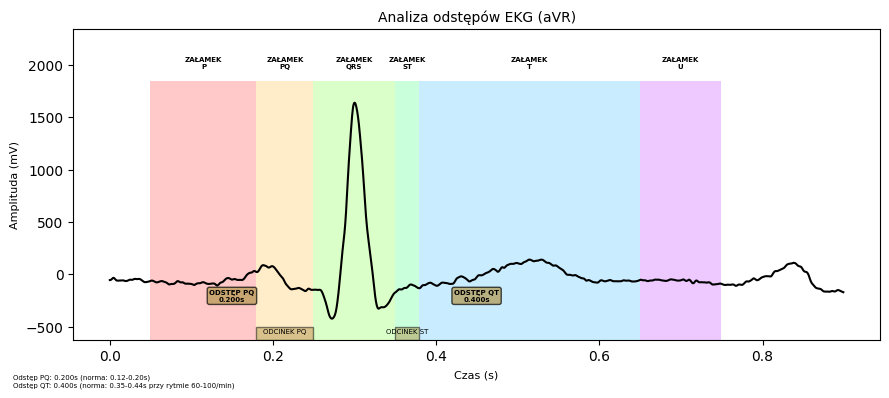

In [8]:
signal_segment = prawaG1[5000:10000]

# Znajdź interwały
interwaly, odstep_pq, odstep_qt, r_peak = znajdz_interwaly_ekg(signal_segment, Fs)

if interwaly:
    # Wyświetl sygnał z zaznaczonymi interwałami
    fig = wyswietl_ekg_z_interwalami(signal_segment, Fs, interwaly, odstep_pq, odstep_qt, r_peak)
    plt.show()
else:
    print("Nie udało się wykryć odpowiednich punktów w sygnale EKG.")



---
W porównaniu do sygnału relaksującego widać, że nasz sygnał nie jest już taki "gładki", natomiast na obrazie nadal wyraźnie widać elementy cyklu sercowego – załamek P, odstęp PQ, zespół QRS, odcinek ST oraz załamek T – przy jednoczesnym zachowaniu prawidłowych czasów trwania, co potwierdza poprawność przewodzenia i repolaryzacji. Tak samo jak w poprzednim przypadku, załamek U jest praktycznie niezauważalny

---



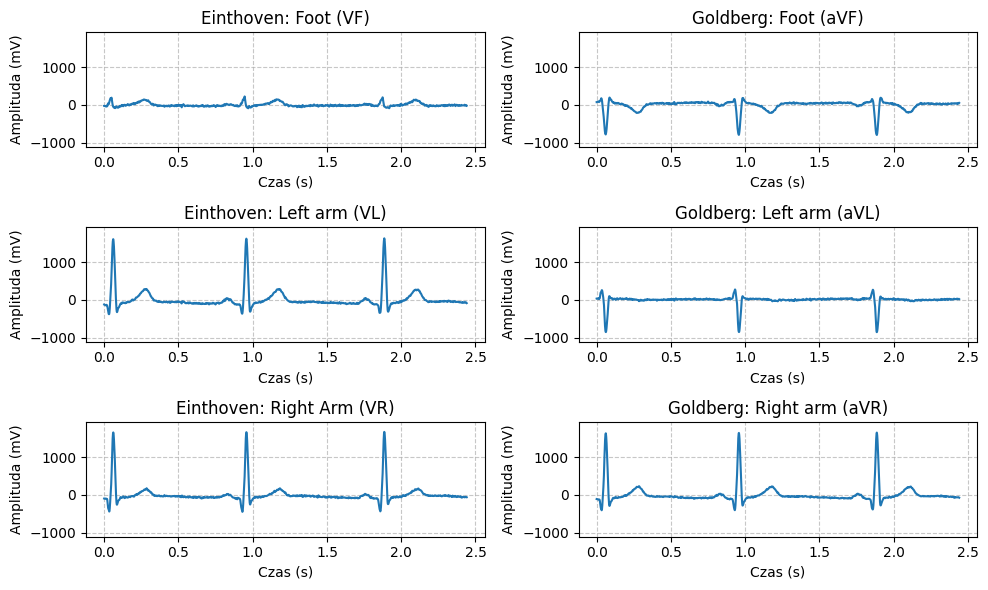

In [9]:
# SYGNAŁ STRES

ekg1, ekg2, ekg3 = wczytywanie("EKGstresującypobudzajacy.obci.raw")
filtered1 = filtry(ekg1, Fs)
filtered2 = filtry(ekg2, Fs)
filtered3 = filtry(ekg3, Fs)

# Montaż Einthovena
noga, lewa, prawa = montaz_einthovena(filtered1, filtered2, filtered3)
t = np.arange(0, len(noga[5000:10000]) / Fs, 1 / Fs)

# Montaż Goldberga
nogaG, lewaG, prawaG1 = montaz_goldberga(filtered1, filtered2, filtered3)
tG = np.arange(0, len(nogaG[5000:10000]) / Fs, 1 / Fs)

# Przygotowanie danych do wyświetlenia
einthoven_data = [noga[5000:10000], lewa[5000:10000], prawa[5000:10000]]
goldberg_data = [nogaG[5000:10000], lewaG[5000:10000], prawaG1[5000:10000]]

# Znalezienie globalnych min i max dla wszystkich sygnałów
all_data = np.concatenate(einthoven_data + goldberg_data)
y_min = np.min(all_data)
y_max = np.max(all_data)

# Dodanie marginesu do wartości skrajnych dla lepszej wizualizacji
margin = (y_max - y_min) * 0.1
y_min -= margin
y_max += margin

# Tworzenie wykresów
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

titles_einthoven = ["Einthoven: Foot (VF)", "Einthoven: Left arm (VL)", "Einthoven: Right Arm (VR)"]
titles_goldberg = ["Goldberg: Foot (aVF)", "Goldberg: Left arm (aVL)", "Goldberg: Right arm (aVR)"]

for i in range(3):
    # Einthoven
    axs[i, 0].plot(t, einthoven_data[i])
    axs[i, 0].set_title(titles_einthoven[i])
    axs[i, 0].set_ylim(y_min, y_max)

    # Goldberg
    axs[i, 1].plot(tG, goldberg_data[i])
    axs[i, 1].set_title(titles_goldberg[i])
    axs[i, 1].set_ylim(y_min, y_max)

for ax in axs.flat:
    ax.set_xlabel("Czas (s)")
    ax.set_ylabel("Amplituda (mV)")
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



---

Przy sygnale stresującym moglibysmy sie spodziewać zwiększonego tętna i o ile gołym okiem nie widać większej ilości pików R, to można zauważyć, że na końcach sygnałów, tak jakby miał zaczynać się już kolejny załamek, co oznacza, że rzeczywiście, minimalnie zwrosło tętno podczas tego sygnału


---



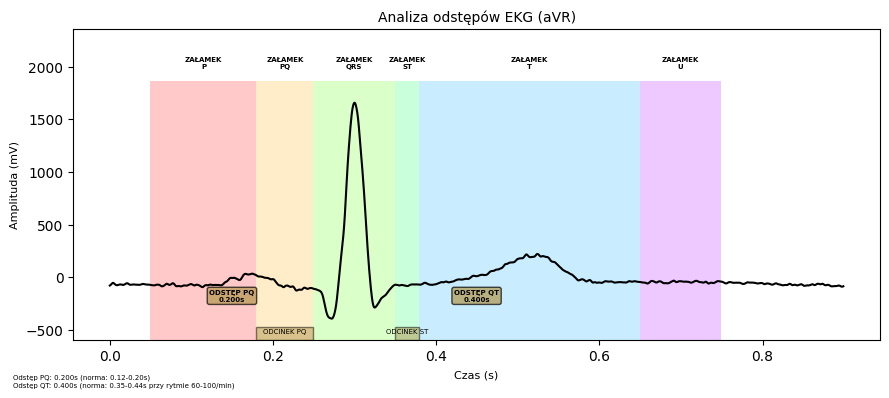

In [10]:
signal_segment = prawaG1[10000:20000]

# Znajdź interwały
interwaly, odstep_pq, odstep_qt, r_peak = znajdz_interwaly_ekg(signal_segment, Fs)

if interwaly:
    # Wyświetl sygnał z zaznaczonymi interwałami
    fig = wyswietl_ekg_z_interwalami(signal_segment, Fs, interwaly, odstep_pq, odstep_qt, r_peak)
    plt.show()
else:
    print("Nie udało się wykryć odpowiednich punktów w sygnale EKG.")



---
Podobnie jak w sygnale spoczynkowym widać, że nasz sygnał nie jest już taki "gładki", natomiast na obrazie nadal wyraźnie widać elementy cyklu sercowego – załamek P, odstęp PQ, zespół QRS, odcinek ST oraz załamek T – przy jednoczesnym zachowaniu prawidłowych czasów trwania, co potwierdza poprawność przewodzenia i repolaryzacji. Tak samo jak w poprzednim przypadku, załamek U jest praktycznie niezauważalny

---



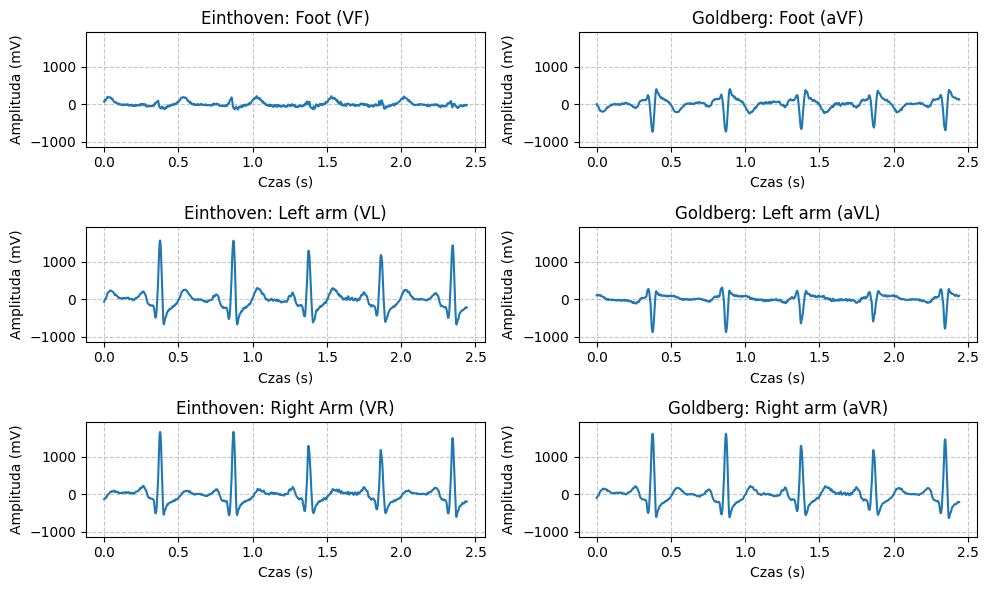

In [11]:
# SYGNAŁ FIZYCZNY

ekg1, ekg2, ekg3 = wczytywanie("EKGfizyczny.obci.raw")
filtered1 = filtry(ekg1, Fs)
filtered2 = filtry(ekg2, Fs)
filtered3 = filtry(ekg3, Fs)

# Montaż Einthovena
noga, lewa, prawa = montaz_einthovena(filtered1, filtered2, filtered3)
t = np.arange(0, len(noga[5000:10000]) / Fs, 1 / Fs)

# Montaż Goldberga
nogaG, lewaG, prawaG1 = montaz_goldberga(filtered1, filtered2, filtered3)
tG = np.arange(0, len(nogaG[5000:10000]) / Fs, 1 / Fs)

# Przygotowanie danych do wyświetlenia
einthoven_data = [noga[5000:10000], lewa[5000:10000], prawa[5000:10000]]
goldberg_data = [nogaG[5000:10000], lewaG[5000:10000], prawaG1[5000:10000]]

# Znalezienie globalnych min i max dla wszystkich sygnałów
all_data = np.concatenate(einthoven_data + goldberg_data)
y_min = np.min(all_data)
y_max = np.max(all_data)

# Dodanie marginesu do wartości skrajnych dla lepszej wizualizacji
margin = (y_max - y_min) * 0.1
y_min -= margin
y_max += margin

# Tworzenie wykresów
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

titles_einthoven = ["Einthoven: Foot (VF)", "Einthoven: Left arm (VL)", "Einthoven: Right Arm (VR)"]
titles_goldberg = ["Goldberg: Foot (aVF)", "Goldberg: Left arm (aVL)", "Goldberg: Right arm (aVR)"]

for i in range(3):
    # Einthoven
    axs[i, 0].plot(t, einthoven_data[i])
    axs[i, 0].set_title(titles_einthoven[i])
    axs[i, 0].set_ylim(y_min, y_max)

    # Goldberg
    axs[i, 1].plot(tG, goldberg_data[i])
    axs[i, 1].set_title(titles_goldberg[i])
    axs[i, 1].set_ylim(y_min, y_max)

for ax in axs.flat:
    ax.set_xlabel("Czas (s)")
    ax.set_ylabel("Amplituda (mV)")
    ax.grid(True, linestyle='--', alpha=0.7)  # Dodanie siatki dla lepszej czytelności

plt.tight_layout()
plt.show()



---

Największą różnice widać natomiast przy sygnale fizycznym, gdzie wszystkie piki mają dużo większe, bardziej niezrównoważone wielkości pików poszczególnych załamków. Jest ich również naturalnie więcej, co wynika z zwiększonego tętna po wysiłku fizycznym

---



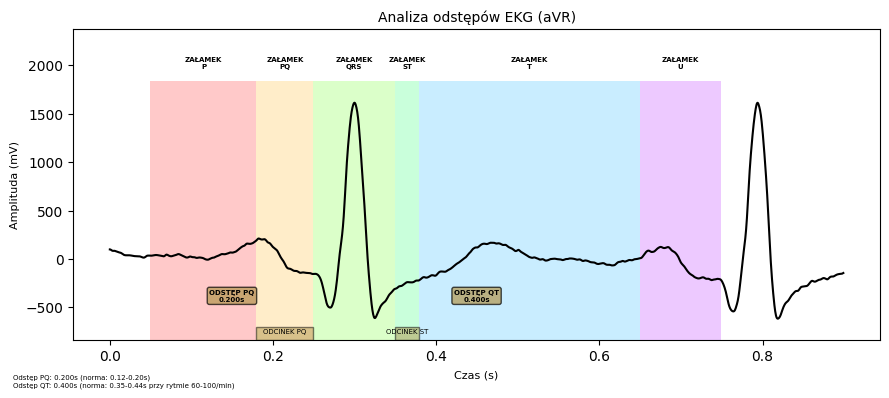

In [12]:
signal_segment = prawaG1[5000:7900]

# Znajdź interwały
interwaly, odstep_pq, odstep_qt, r_peak = znajdz_interwaly_ekg(signal_segment, Fs)

if interwaly:
    # Wyświetl sygnał z zaznaczonymi interwałami
    fig = wyswietl_ekg_z_interwalami(signal_segment, Fs, interwaly, odstep_pq, odstep_qt, r_peak)
    plt.show()
else:
    print("Nie udało się wykryć odpowiednich punktów w sygnale EKG.")



---


Największą różnice widać w sygnale fizycznym, gdzie poszczególne załamki mają największą amplitudę. Na wykresie wciąż wyraźnie widać elementy cyklu sercowego – załamek P, odstęp PQ, zespół QRS, odcinek ST oraz załamek T – przy jednoczesnym zachowaniu prawidłowych czasów trwania, co potwierdza poprawność przewodzenia i repolaryzacji. Tak samo jak w poprzednim przypadku, załamek U jest praktycznie niezauważalny, a na wykresie po prostu widać początek następnego sygnału.


---



### **Ćwiczenie 3 i 4:** Detekcja pików R i wykreślenie tętna

W tym ćwiczeniu należało wybrać najlepszy sygnał do analizy, oraz znaleźć piki R oraz wykreślić tętno. Do analizy wybrałem sygnał relaksujący z montażem goldberga, wydaję się on dobrym kandydatem, z racji na widoczność poszczególnych załamków w sygnale

Średnie tętno dla Sygnał relaksujący: 66.75 BPM
Odchylenie standardowe dla Sygnał relaksujący: 5.87 BPM
Analizuję Sygnał fizyczny tylko w zakresie 100-300 sekund
Średnie tętno dla Sygnał fizyczny, 94.57 BPM
Odchylenie standardowe dla Sygnał fizyczny, 17.61 BPM
Średnie tętno dla Sygnał stresujący: 67.39 BPM
Odchylenie standardowe dla Sygnał stresujący: 14.12 BPM
Średnie tętno dla Sygnał spoczynkowy: 72.17 BPM
Odchylenie standardowe dla Sygnał spoczynkowy: 7.19 BPM


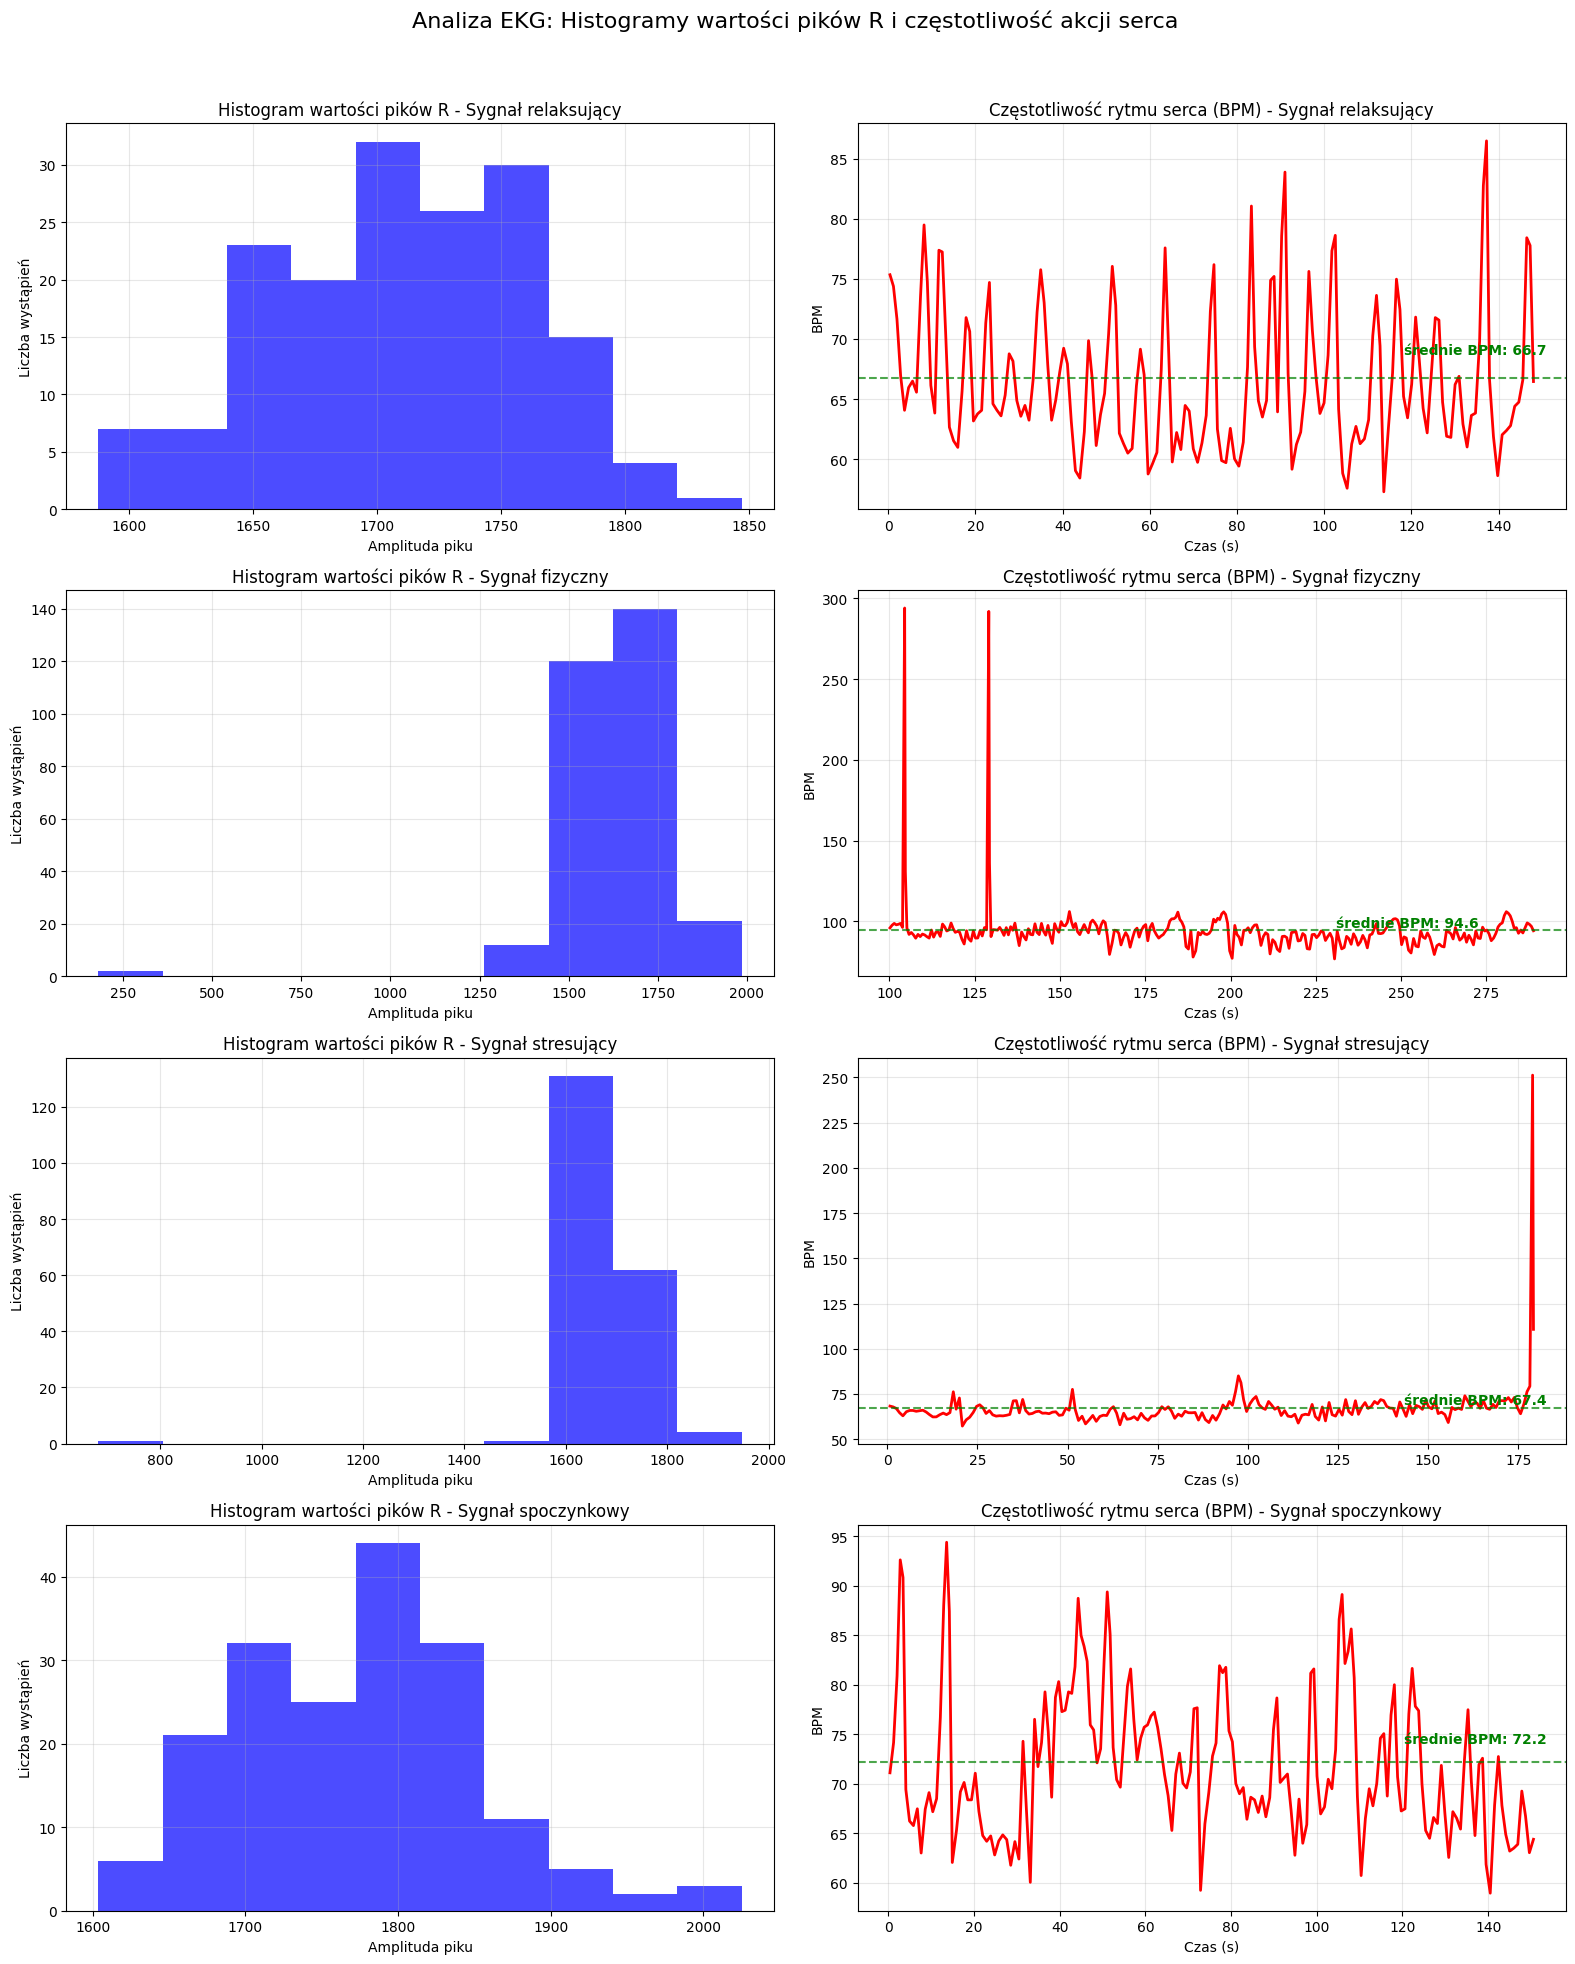


Podsumowanie wyników:
Sygnał relaksujący: 66.7 ± 5.9 BPM
Sygnał fizyczny (zakres 100-300s): 94.6 ± 17.6 BPM
Sygnał stresujący: 67.4 ± 14.1 BPM
Sygnał spoczynkowy: 72.2 ± 7.2 BPM


In [13]:
# SYGNAŁ RELAKSUJĄCY
ekg1, ekg2, ekg3 = wczytywanie("EKGrelaksujący.obci.raw")
filtered1 = filtry(ekg1, Fs)
filtered2 = filtry(ekg2, Fs)
filtered3 = filtry(ekg3, Fs)

#SYGNAŁ FIZYCZNY
ekg1F, ekg2F, ekg3F = wczytywanie("EKGfizyczny.obci.raw")
filtered1F = filtry(ekg1F, Fs)
filtered2F = filtry(ekg2F, Fs)
filtered3F = filtry(ekg3F, Fs)

#SYGNAŁ STRESUJĄCY
ekg1stres, ekg2stres, ekg3stres = wczytywanie("EKGstresującypobudzajacy.obci.raw")
filtered1stres = filtry(ekg1stres, Fs)
filtered2stres = filtry(ekg2stres, Fs)
filtered3stres = filtry(ekg3stres, Fs)

#SYGNAŁ SPOCZYNKOWY
ekg1spocz, ekg2spocz, ekg3spocz = wczytywanie("EKGspoczynkowy1.obci.raw")
filtered1spocz = filtry(ekg1spocz, Fs)
filtered2spocz = filtry(ekg2spocz, Fs)
filtered3spocz = filtry(ekg3spocz, Fs)

nogaG, lewaG, prawaG = montaz_goldberga(filtered1, filtered2, filtered3)
nogaGF, lewaGF, prawaGF = montaz_goldberga(filtered1F, filtered2F, filtered3F)
nogaGstres, lewaGstres, prawaGstres = montaz_goldberga(filtered1stres, filtered2stres, filtered3stres)
nogaGspocz, lewaGspocz, prawaGspocz = montaz_goldberga(filtered1spocz, filtered2spocz, filtered3spocz)
tG = np.arange(0, len(nogaG[:5000]) / Fs, 1 / Fs)


def detekcja_pikow_R(sygnal, fs, prominence=700, width=1, bins=10, nazwa_sygnalu=""):
    """
    Wykrywa piki R w sygnale EKG i oblicza częstość akcji serca.

    Args:
        sygnal: Sygnał EKG
        fs: Częstotliwość próbkowania
        prominence: Minimalna wysokość piku
        width: Minimalna szerokość piku
        bins: Liczba przedziałów histogramu
        nazwa_sygnalu: Nazwa sygnału do wyświetlenia na wykresach

    Returns:
        figury: Lista figur z wykresami
        dane: Krotka (indeksy_pikow, wartosci_pikow, t_puls, odwrotnosc)
    """
    # Wykrywanie pików R
    indeksy_pikow, wlasciwosci = ss.find_peaks(sygnal, prominence=prominence, width=width)

    if len(indeksy_pikow) == 0:
        print(f"Brak wykrytych pików R dla sygnału: {nazwa_sygnalu}")
        return [], ([], [], [], [])

    wartosci_pikow = sygnal[indeksy_pikow]

    # Obliczanie odstępów między pikami
    sekundy = indeksy_pikow / fs
    dt = np.diff(sekundy)

    if len(dt) == 0:
        print(f"Za mało pikówk R wykrytych dla sygnału: {nazwa_sygnalu}")
        return [], (indeksy_pikow, wartosci_pikow, [], [])

    # Obliczanie częstości akcji serca (BPM)
    odwrotnosc = 1 / dt * 60
    t_puls = sekundy[:-1]

    # Tworzenie wykresów
    fig1 = plt.figure(figsize=(8, 4))
    plt.hist(wartosci_pikow, bins=bins)
    plt.title(f"Histogram wartości pików R - {nazwa_sygnalu}")
    plt.xlabel("Amplituda piku")
    plt.ylabel("Liczba wystąpień")
    plt.tight_layout()

    fig2 = plt.figure(figsize=(8, 4))
    plt.plot(t_puls, odwrotnosc, 'r-')
    plt.title(f"Częstotliwość rytmu serca (BPM) - {nazwa_sygnalu}")
    plt.xlabel("Czas (s)")
    plt.ylabel("BPM")
    plt.grid(True)
    plt.tight_layout()

    # Obliczanie statystyk
    srednia_bpm = np.mean(odwrotnosc)
    odch_bpm = np.std(odwrotnosc)
    print(f"Średnie tętno dla {nazwa_sygnalu}: {srednia_bpm:.2f} BPM")
    print(f"Odchylenie standardowe dla {nazwa_sygnalu}: {odch_bpm:.2f} BPM")

    return [fig1, fig2], (indeksy_pikow, wartosci_pikow, t_puls, odwrotnosc)


fig, axs = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle("Analiza EKG: Histogramy wartości pików R i częstotliwość akcji serca", fontsize=16)

# Lista sygnałów z nazwami
sygnaly = [
    (prawaG, "Sygnał relaksujący"),
    (prawaGF, "Sygnał fizyczny"),
    (prawaGstres, "Sygnał stresujący"),
    (prawaGspocz, "Sygnał spoczynkowy")
]

# Wartości do dostosowania detekcji pików dla różnych sygnałów
parametry = [
    {"prominence": 700, "width": 1}, # dla sygnału relaksującego
    {"prominence": 700, "width": 1}, # dla sygnału fizycznego
    {"prominence": 700, "width": 1}, # dla sygnału stresującego
    {"prominence": 700, "width": 1}  # dla sygnału spoczynkowego
]

# Wszystkie dane BPM do późniejszego porównania
wszystkie_bpm = []

# Analiza każdego sygnału
for i, ((sygnal, nazwa), params) in enumerate(zip(sygnaly, parametry)):

    # Przygotowanie sygnału - dla sygnału fizycznego wybieramy tylko fragment 100-300s
    if nazwa == "Sygnał fizyczny":
        # Konwersja sekund na indeksy próbek
        indeks_start = int(110 * Fs)
        indeks_koniec = int(300 * Fs)

        # Ograniczenie sygnału tylko do wybranego zakresu
        analizowany_sygnal = sygnal[indeks_start:indeks_koniec]
        print(f"Analizuję {nazwa} tylko w zakresie 100-300 sekund")
    else:
        analizowany_sygnal = sygnal

    # Wykrywanie pików R i obliczanie BPM
    indeksy_pikow, wlasciwosci = ss.find_peaks(analizowany_sygnal, prominence=params["prominence"], width=params["width"])

    if len(indeksy_pikow) < 2:
        print(f"Za mało pików R wykrytych dla sygnału: {nazwa}")
        axs[i, 0].text(0.5, 0.5, "Za mało pików R", ha='center', va='center')
        axs[i, 1].text(0.5, 0.5, "Za mało pików R", ha='center', va='center')
        continue

    wartosci_pikow = analizowany_sygnal[indeksy_pikow]

    # Obliczanie odstępów między pikami z uwzględnieniem przesunięcia dla sygnału fizycznego
    if nazwa == "Sygnał fizyczny":
        # Dodajemy przesunięcie 100s do indeksów, aby wykres pokazywał właściwy czas
        sekundy = (indeksy_pikow / Fs) + 100
    else:
        sekundy = indeksy_pikow / Fs

    dt = np.diff(sekundy)

    # Obliczanie częstości akcji serca (BPM)
    odwrotnosc = 1 / dt * 60
    t_puls = sekundy[:-1]

    # Rysowanie histogramu
    axs[i, 0].hist(wartosci_pikow, bins=10, color='blue', alpha=0.7)
    axs[i, 0].set_title(f"Histogram wartości pików R - {nazwa}")
    if nazwa == "Sygnał fizyczny":
        axs[i, 0].set_title(f"Histogram wartości pików R - {nazwa}")
    axs[i, 0].set_xlabel("Amplituda piku")
    axs[i, 0].set_ylabel("Liczba wystąpień")
    axs[i, 0].grid(True, alpha=0.3)

    # Rysowanie wykresu BPM
    axs[i, 1].plot(t_puls, odwrotnosc, 'r-', linewidth=2)
    axs[i, 1].set_title(f"Częstotliwość rytmu serca (BPM) - {nazwa}")
    if nazwa == "Sygnał fizyczny":
        axs[i, 1].set_title(f"Częstotliwość rytmu serca (BPM) - {nazwa}")
    axs[i, 1].set_xlabel("Czas (s)")
    axs[i, 1].set_ylabel("BPM")
    axs[i, 1].grid(True, alpha=0.3)

    # Pozioma linia dla średniego BPM
    srednie_bpm = np.mean(odwrotnosc)
    axs[i, 1].axhline(y=srednie_bpm, color='g', linestyle='--', alpha=0.7)
    axs[i, 1].text(np.max(t_puls)*0.8, srednie_bpm+2,
                 f"średnie BPM: {srednie_bpm:.1f}",
                 color='g', fontweight='bold')

    # Dodanie statystyk
    odch_bpm = np.std(odwrotnosc)
    if nazwa == "Sygnał fizyczny":
        print(f"Średnie tętno dla {nazwa}, {srednie_bpm:.2f} BPM")
        print(f"Odchylenie standardowe dla {nazwa}, {odch_bpm:.2f} BPM")
    else:
        print(f"Średnie tętno dla {nazwa}: {srednie_bpm:.2f} BPM")
        print(f"Odchylenie standardowe dla {nazwa}: {odch_bpm:.2f} BPM")

    # Zapisanie wartości BPM do późniejszego porównania
    if nazwa == "Sygnał fizyczny":
        wszystkie_bpm.append((f"{nazwa} (zakres 100-300s)", srednie_bpm, odch_bpm))
    else:
        wszystkie_bpm.append((nazwa, srednie_bpm, odch_bpm))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Obszar dla głównego tytułu

# Dodanie podsumowania
podsumowanie = "Podsumowanie średniego tętna:\n"
for nazwa, srednia, odch in wszystkie_bpm:
    podsumowanie += f"{nazwa}: {srednia:.1f} ± {odch:.1f} BPM\n"

plt.show()

print("\nPodsumowanie wyników:")
for nazwa, srednia, odch in wszystkie_bpm:
    print(f"{nazwa}: {srednia:.1f} ± {odch:.1f} BPM")


#Sygnał relaksujący
Przyjrzyjmy się wykresom. Histogram dobrze prezentuje rozkład amplitud wykrytych pików R. Większośc pików mieści się w oczekiwanym zakresie, co sugeruje, że detekcja przebiegła poprawnie

Rozkład jest skupiony wokół jednej wartości, oznacza to, że amplitudy są dość jednorodne, co świadczy o dobrej jakości sygnału ( znaczy, że został dobrze dobrany)

Jeśli chodzi o drugi wykres tj. Częstotliwość rytmu serca. Również można przyjąć, że jest on poprawnie wykreślony. Świadczą o tym, relatywnie nie duże flutkuacje od wartości średniej tętna.

#Sygnał spoczynkowy
Podobnie jak do sygnału relaksujące histogram dobrze prezentuje rozklad amplitud wykrytych pików R, które mieszą się w oczekiwanym zakresie.

Częstotliwość rytmu serca, również wydaje się poprawnie wykreślony, patrząc na to, że nie istnieją duże flutkuacje od wartości średniej tętna.

#Sygnał fizyczny
Przy analizie sygnału fizycznego, zdecydowano się na przeprowadzenie analizy od 100 sekundy do 300 sekundy sygnały, ze względu na gigantyczne amplitudy BPM, które powodowały zakłócenie poprawności wyników.

Analizując histogram można zauważyć szerszy rozkład amplitud pików, wskazującym na większe wahania w zależności od obciążenia lub stanu pobudzenia. W naszym przypadku jest to dosyć zrozumiale, ponieważ nasze tętno po zmęczeniu stopniowo się obniżało wraz z biegiem czasu, przez co piki R mogą być nierównomiernie rozmieszczone.

Analizując wykres tętna można zauważyć dosyć duże odchylenie standardowe, co znowu nie jest niczym niespodziewanym, ponieważ jak juz wcześniej wspomniano, tętno wraz z czasem pomiaru malało.

#Sygnał stresujący

Podobnie jak w sygnale stresującym możemy zauważyć pojedyńcze odstąpenia od normy, analizując histogram wartości pików R.

Analizując wykres tętna, pomijając końcowe wartości BPM sygnału, można stwierdzić, że poprawnie przedstawia wykreślenie tętna.



### Ćwiczenie 5: HRV

HRV (ang. Heart Rate Variability) to miara zmienności odstępów czasowych między kolejnymi uderzeniami serca, odzwierciedlająca zdolność organizmu do adaptacji oraz równowagę autonomicznego układu nerwowego. W tym cwiczeniu należało przedstawić interwały R-R jako szereg czasowy oraz wystestymować widma częstotliwościowe tych sygnałów.

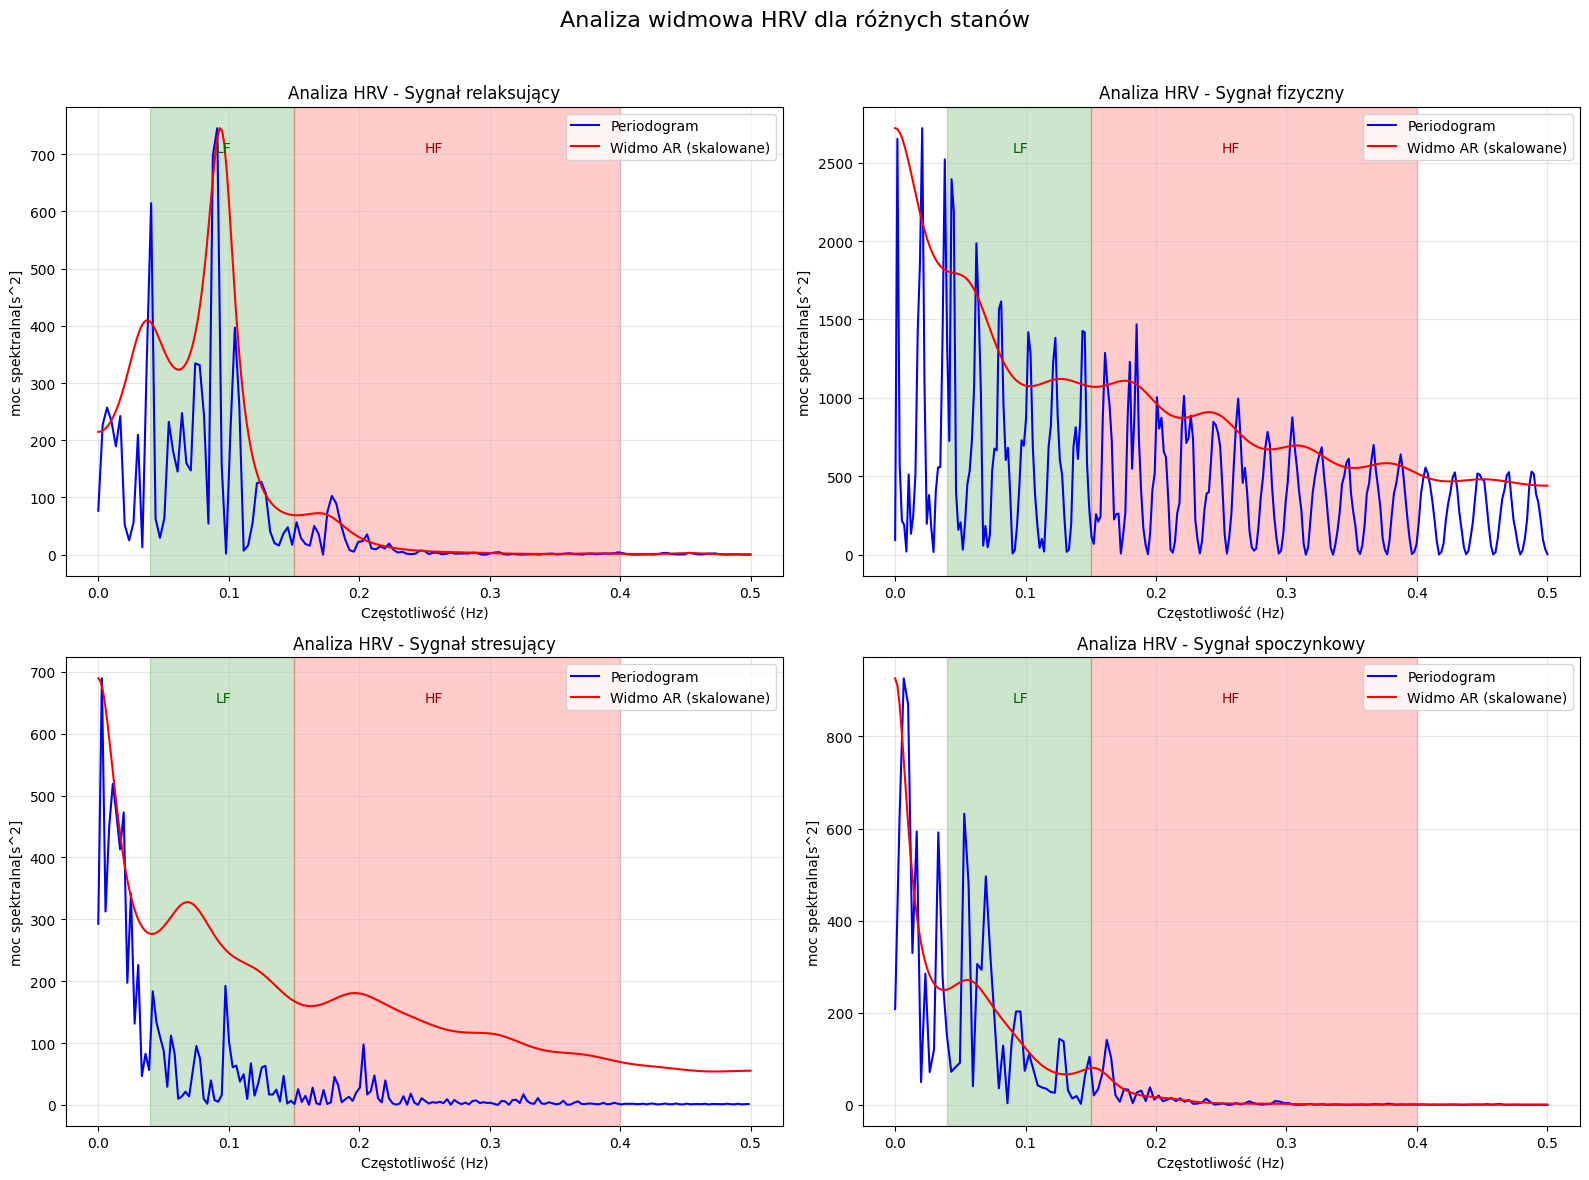

In [17]:
def analiza_HRV(t_puls, odwrotnosc, nazwa_sygnalu="", rzad_AR=16, maksymalnyRzad=20, Fs=1, krok_interpolacji=0.5):
    """
    Wykonuje analizę zmienności rytmu serca (HRV) za pomocą widma AR i periodogramu

    Args:
        t_puls: Tablica czasów wystąpienia pikow R (w sekundach)
        odwrotnosc: Wartości BPM (tętno) dla każdego punktu w t_puls
        nazwa_sygnalu: Nazwa analizowanego sygnału do wyświetlenia na wykresie
        rzad_AR: Rząd modelu autoregresyjnego
        maksymalnyRzad: Maksymalny rząd do oceny kryterium AIC
        Fs: Częstotliwość próbkowania dla interpretacji widma (Hz)
        krok_interpolacji: Krok interpolacji (w sekundach)

    Returns:
        dane: Krotka (f_AR, Sp_AR, F_per, P_per) z wynikami analizy
    """
    # Sprawdzenie czy mamy wystarczająco danych
    if len(t_puls) < 2 or len(odwrotnosc) < 2:
        print(f"Za mało punktów do analizy HRV dla sygnału: {nazwa_sygnalu}")
        return None, None, None, None

    # Interpolacja HRV
    cos_interpolacja = np.arange(0, t_puls[-1], krok_interpolacji)
    interpolacja = np.interp(cos_interpolacja, t_puls, odwrotnosc)

    # Odjęcie średniej dla analizy AR
    srednia_sygnalu = np.mean(interpolacja)
    x_AR = interpolacja - srednia_sygnalu

    # Kryterium AIC
    def kryterium_AIC(x, maksymalnyRzad):
        N = len(x)
        AIC = np.zeros(maksymalnyRzad)
        for p in range(1, maksymalnyRzad + 1):
            a, sigma = parametryAR(x, p)
            AIC[p - 1] = 2 * p / N + np.log(sigma ** 2)
        return np.arange(1, maksymalnyRzad + 1), AIC

    # Obliczenie parametrów AR
    def parametryAR(x, p):
        N = len(x)
        ak = np.correlate(x, x, mode='full')
        norm_ak = np.hstack((np.arange(1, N + 1), np.arange(N - 1, 0, -1)))
        ak /= norm_ak
        R = ak[N - 1:]
        RL = R[1:p + 1]
        RP = np.array([ak[N - 1 - i:N - 1 - i + p] for i in range(p)])
        a = np.linalg.solve(RP, RL)
        sigma = np.sqrt(ak[N - 1] - np.sum(a * ak[N:N + p]))
        return a, sigma

    # Obliczenie widma AR
    def widmoAR(parametry_a, sigma, N_punktow, Fs):
        f = np.linspace(0, Fs / 2, N_punktow)
        z = np.exp(1j * 2 * np.pi * f / Fs)
        A = np.ones(N_punktow, dtype=complex)
        for i in range(len(parametry_a)):
            A -= parametry_a[i] * z ** (-(i + 1))
        H = 1. / A
        Sp = (H * sigma ** 2 * H.conj()).real / Fs
        return f, Sp

    # Obliczenie AIC (ale nie używamy tego w tym kodzie)
    rzedy, AIC = kryterium_AIC(x_AR, maksymalnyRzad)

    # Estymacja parametrów AR
    a, sigma = parametryAR(x_AR, rzad_AR)
    f_AR, Sp_AR = widmoAR(a, sigma, len(x_AR), Fs)

    # Widmo periodogramem
    okno = np.hamming(len(interpolacja))
    okno /= np.linalg.norm(okno)
    F_per, P_per = ss.periodogram(interpolacja, fs=Fs, window=okno, scaling="density")

    return f_AR, Sp_AR, F_per, P_per


# Utworzenie figury zbiorczej
plt.figure(figsize=(16, 12))
plt.suptitle("Analiza widmowa HRV dla różnych stanów", fontsize=16)

# Przygotowanie listy danych do analizy HRV
sygnaly_HRV = []

# Wykorzystanie zmiennych z pierwszego kodu
for i, ((sygnal, nazwa), params) in enumerate(zip(sygnaly, parametry)):
    # Przygotowanie sygnału - dla sygnału fizycznego wybieramy tylko fragment 100-300s
    if nazwa == "Sygnał fizyczny":
        indeks_start = int(110 * Fs)
        indeks_koniec = int(300 * Fs)
        analizowany_sygnal = sygnal[indeks_start:indeks_koniec]
    else:
        analizowany_sygnal = sygnal

    # Detekcja pików R
    indeksy_pikow, wlasciwosci = ss.find_peaks(analizowany_sygnal, prominence=params["prominence"], width=params["width"])

    if len(indeksy_pikow) < 2:
        print(f"Za mało pików R wykrytych dla sygnału: {nazwa}")
        continue

    # Obliczanie czasów wystąpienia pików w sekundach
    if nazwa == "Sygnał fizyczny":
        sekundy = (indeksy_pikow / Fs) + 100
    else:
        sekundy = indeksy_pikow / Fs

    dt = np.diff(sekundy)
    odwrotnosc = 1 / dt * 60  # BPM
    t_puls = sekundy[:-1]

    # Dodanie do listy do analizy HRV
    sygnaly_HRV.append((t_puls, odwrotnosc, nazwa))

# Analiza HRV dla każdego sygnału i tworzenie wykresów w układzie 2x2
for i, (t_puls, bpm, nazwa) in enumerate(sygnaly_HRV):
    # Analiza HRV
    f_AR, Sp_AR, F_per, P_per = analiza_HRV(t_puls, bpm, nazwa)

    # Tworzenie wykresu w odpowiedniej pozycji (układ 2x2)
    plt.subplot(2, 2, i+1)

    # Rysowanie widm Z przeskalowaniem widma AR dla lepszej widoczności
    plt.plot(F_per, P_per, 'b-', linewidth=1.5, label="Periodogram")

    # Przeskalowanie widma AR do zakresu periodogramu
    skala = np.max(P_per) / np.max(Sp_AR) if np.max(Sp_AR) > 0 else 1
    plt.plot(f_AR, Sp_AR * skala, 'r-', linewidth=1.5, label="Widmo AR (skalowane)")

    plt.title(f"Analiza HRV - {nazwa}")
    plt.xlabel("Częstotliwość (Hz)")
    plt.ylabel("moc spektralna[s^2]")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Oznaczenie stref częstotliwości HRV
    plt.axvspan(0.04, 0.15, alpha=0.2, color='g')
    plt.axvspan(0.15, 0.4, alpha=0.2, color='r')
    plt.text(0.09, plt.ylim()[1]*0.9, 'LF', color='darkgreen')
    plt.text(0.25, plt.ylim()[1]*0.9, 'HF', color='darkred')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Sygnał relaksujący
W przypadku sygnału relaksacyjnego widmo HRV wyznaczone zarówno metodą AR, jak i periodogramu wykazuje wyraźny pik w obszarze niskich częstotliwości (LF: 0,04–0,15 Hz), sugerujący dominujący wpływ aktywności współczulno-przywspółczulnej. Metoda AR pozwala na uwypuklenie wąskich pików w widmie i nieco lepiej odwzorowuje lokalne maksima, natomiast periodogram oddaje całościowy rozkład mocy w pełnym zakresie częstotliwości.

# Sygnał fizyczny
Sygnał fizyczny, wycięty w przedziale 100–300 s, charakteryzuje się szerszym i bardziej rozproszonym widmem, co jest typowe dla stanów wywołanych aktywnością fizyczną. Względnie wysoki poziom mocy obserwuje się w pasmach LF i HF (0,15–0,4 Hz), wskazując na wzmocnioną regulację układu nerwowego w odpowiedzi na wysiłek. Metoda AR dobrze odwzorowuje główne piki, a periodogram potwierdza silną zawartość w wyższych częstotliwościach.

# Sygnał stresujący
W widmie HRV dla sygnału stresującego zauważalny jest wzrost intensywności w obszarze LF, przy jednoczesnym stosunkowo mniejszym udziale zakresu HF. Odbija to przewagę komponentu współczulnego układu nerwowego w warunkach stresu. Estymacja AR podkreśla dominujące składowe w niskich częstotliwościach, natomiast periodogram dostarcza pełniejszej informacji o rozkładzie energii także w obszarze wysokich częstotliwości.

#Sygnał spoczynkowy
Sygnał spoczynkowy charakteryzuje się wyraźną obecnością pasma LF i dobrze zaznaczonym pasmem HF, co świadczy o zrównoważonej aktywności autonomicznej. Zarówno metoda AR, jak i periodogram pokazują stosunkowo wąskie piki w tych częstotliwościach, co odzwierciedla ustabilizowany rytm serca. Analiza AR wydaje się bardziej gładka i sprzyja identyfikacji głównych pików, zaś periodogram pomaga zweryfikować rozkład mocy w całym zakresie częstotliwości.